# K- means

In [27]:
import os
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master local[*] pyspark-shell"

import findspark
findspark.init()

import pyspark
#import SparkSession
from pyspark.sql import SparkSession

In [28]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('k_means').getOrCreate()

In [29]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.sql.functions import rand, randn
from pyspark.ml.clustering import KMeans

In [30]:
df=spark.read.csv('iris_dataset.csv',inferSchema=True,header=True)

In [31]:
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [32]:
print((df.count(),len(df.columns)))

(150, 5)


In [33]:
df.columns

['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

There is a total of five columns out of which four are numerical and the
label column is categorical.

In [34]:
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [35]:
df.orderBy(rand()).show(10,False)

+------------+-----------+------------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species   |
+------------+-----------+------------+-----------+----------+
|4.6         |3.4        |1.4         |0.3        |setosa    |
|5.0         |3.5        |1.3         |0.3        |setosa    |
|5.1         |3.3        |1.7         |0.5        |setosa    |
|5.8         |2.7        |3.9         |1.2        |versicolor|
|6.7         |3.3        |5.7         |2.1        |virginica |
|4.8         |3.1        |1.6         |0.2        |setosa    |
|4.8         |3.4        |1.6         |0.2        |setosa    |
|6.9         |3.1        |5.4         |2.1        |virginica |
|5.7         |4.4        |1.5         |0.4        |setosa    |
|6.4         |2.7        |5.3         |1.9        |virginica |
+------------+-----------+------------+-----------+----------+
only showing top 10 rows



In [36]:
df.select('species').distinct().count()

3

In [37]:
df.groupBy('species').count().orderBy('count',ascending=False).show(10,False)

+----------+-----+
|species   |count|
+----------+-----+
|virginica |50   |
|versicolor|50   |
|setosa    |50   |
+----------+-----+



In [38]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [39]:
input_cols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [40]:
# Transform all features into a vector using VectorAssembler
vec_assembler = VectorAssembler(inputCols = input_cols, outputCol='features')
final_data = vec_assembler.transform(df)

## Build K-Means Clustering Model

In [41]:
errors=[]

for k in range(2,10):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(final_data)
    intra_distance = model.computeCost(final_data)
    errors.append(intra_distance)
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(intra_distance))
    print('--'*30)

With K=2
Within Set Sum of Squared Errors = 152.36870647734008
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 78.94084142614648
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 57.31787321428577
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 53.07030589080482
------------------------------------------------------------
With K=6
Within Set Sum of Squared Errors = 45.786554732159516
------------------------------------------------------------
With K=7
Within Set Sum of Squared Errors = 35.28283172423713
------------------------------------------------------------
With K=8
Within Set Sum of Squared Errors = 36.06904654282825
------------------------------------------------------------
With K=9
Within Set Sum of Squared Errors = 31.934947207958473
------------------------------------------------------------


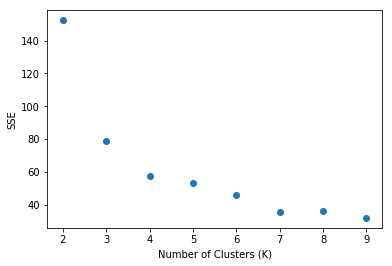

In [42]:
cluster_number = range(2,10)
plt.scatter(cluster_number,errors)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.show()

In [52]:
#Selecting k =3 for kmeans clustering
kmeans = KMeans(featuresCol='features',k=3,)

In [53]:
model = kmeans.fit(final_data)

In [54]:
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         2|   38|
|         0|   62|
+----------+-----+



We can use the transform function to assign the cluster
number to the original dataset and use a groupBy function to validate the
groupings.

In [55]:
predictions = model.transform(final_data)

In [56]:
predictions.columns

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'species',
 'features',
 'prediction']

As it can be observed, the setosa species is perfectly grouped
along with versicolor, almost being captured in the same cluster,
but verginica seems to fall within two different groups.

In [57]:
predictions.groupBy('species','prediction').count().show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
| virginica|         2|   36|
| virginica|         0|   14|
|versicolor|         0|   48|
|    setosa|         1|   50|
|versicolor|         2|    2|
+----------+----------+-----+



## Visualization of Clusters

Visualization of Clusters
In the final step, we can visualize the new clusters with the help of Python’s
matplotlib library. In order to do that, we convert our Spark dataframe into
a Pandas dataframe first

In [49]:
pandas_df = predictions.toPandas()
pandas_df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species,features,prediction
19,5.1,3.8,1.5,0.3,setosa,"[5.1, 3.8, 1.5, 0.3]",1
97,6.2,2.9,4.3,1.3,versicolor,"[6.2, 2.9, 4.3, 1.3]",0
39,5.1,3.4,1.5,0.2,setosa,"[5.1, 3.4, 1.5, 0.2]",1
146,6.3,2.5,5.0,1.9,virginica,"[6.3, 2.5, 5.0, 1.9]",0
10,5.4,3.7,1.5,0.2,setosa,"[5.4, 3.7, 1.5, 0.2]",1


In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

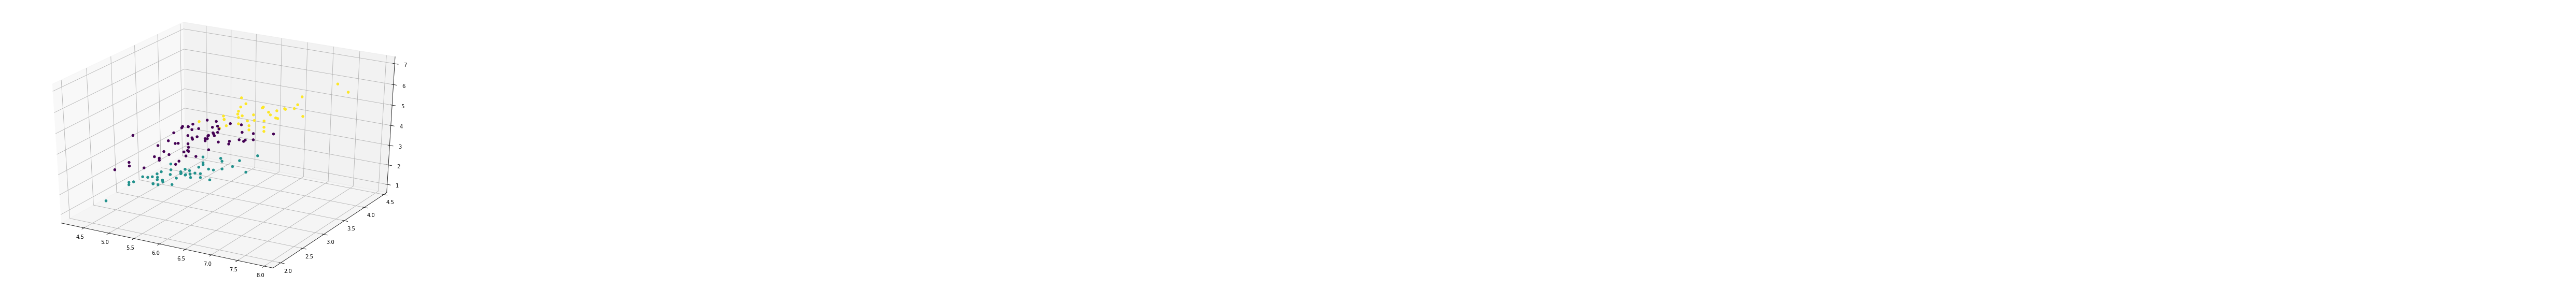

In [51]:
cluster_vis = plt.figure(figsize=(15,10)).gca(projection='3d')
cluster_vis.scatter(pandas_df.sepal_length, pandas_df.sepal_width, pandas_df.petal_length, c=pandas_df.prediction,depthshade=False)
plt.show()